# Train models to predict molecular inhibitors of *PARP1*

Aims: Create a script to train a model and make predictions about drugs that can inhibit the protein *PARP1*.


Background:
Alzheimer's disease is the most common age-related neurodegenerative disorder. Familial forms of Alzheimer's disease associated with the accumulation of a toxic form of amyloid-β peptides are linked to mitochondrial impairment. The coenzyme nicotinamide adenine dinucleotide (NAD+) is essential for both mitochondrial bioenergetics and nuclear DNA repair through NAD+-consuming poly (ADP-ribose) polymerases (PARPs). PARP overactivation can deplete neurons from NAD+, and lead to neurodegeneration. Recent research found that mutations in the PARP-1 protein leading to decreased PARP-1 activity are protective against Alzheimer’s disease



## Load libraries



In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 75.3 MB/s eta 0:00:00


In [2]:
pip install --upgrade gensim

In [3]:
!pip install mordred

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.7 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176721 sha256=7390194679d2384c219a5ca7d2e4fa13a6ba9101369ac32ed2eb4b793922a088
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


In [4]:
#Installing a package
!pip install git+https://github.com/samoturk/mol2vec;

  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-4_xo77nt
  Running command git clone --filter=blob:none --quiet https://github.com/samoturk/mol2vec /tmp/pip-req-build-4_xo77nt
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.3 MB/s eta 0:00:00
  Created wheel for mol2vec: filename=mol2vec-0.1-py3-none-any.whl size=14015 sha256=3f82dbfa6eb4e5021acf2aeae490de155f7127458bf28529519fed2c489cef0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-nom3l5sj/wheels/b9/bd/e0/b6dd7c5e346247e8d6944e08ca1c262a908231747f4efa539d
Successfully built mol2vec


In [5]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from collections import Counter
import seaborn as sns

from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolDescriptors import GetAtomPairFingerprint
from rdkit.Chem.AtomPairs import Torsions
warnings.filterwarnings("ignore")
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

from sklearn.metrics import mean_absolute_error, mean_squared_error
from gensim.models import word2vec
from gensim.models import KeyedVectors

from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec
from gensim.models import word2vec
from mordred import Calculator, descriptors

#constructs a so-called 'molecular sentence' with desired Morgan fingerprints' radius

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import data

In [7]:
#df= pd.read_csv('drive/MyDrive/tmp/Yvonne/dt/bioactivity_gene.csv')
df= pd.read_csv('/content/drive/MyDrive/Yvonne/dt/bioactivity_gene.csv')

df

,baid,activity,aid,sid,cid,geneid,pmid,aidtype,aidmdate,hasdrc,...,aidsrcname,aidname,cmpdname,targetname,targeturl,ecs,repacxn,taxids,cellids,targettaxid
0,100596770,Active,240189,103459594,25190931,142,16078828.0,Confirmatory,20181018,0,...,ChEMBL,Effective concentration against poly ADP-ribos...,"8-Fluoro-5,6-dihydro-11H-indeno[1,2-c]isoquino...",PARP1 - poly(ADP-ribose) polymerase 1 (human),/gene/142,2.4.2.-|2.4.2.30,P09874,9606,NaN,NaN
1,100596771,Active,240189,103459595,25190932,142,16078828.0,Confirmatory,20181018,0,...,ChEMBL,Effective concentration against poly ADP-ribos...,"9-Fluoro-5,6-dihydro-11H-indeno[1,2-c]isoquino...",PARP1 - poly(ADP-ribose) polymerase 1 (human),/gene/142,2.4.2.-|2.4.2.30,P09874,9606,NaN,NaN
2,100596773,Active,240189,103459739,11336543,142,16078828.0,Confirmatory,20181018,0,...,ChEMBL,Effective concentration against poly ADP-ribos...,"1-{8-Oxo-9-azatetracyclo[8.7.0.0^{2,7}.0^{11,1...",PARP1 - poly(ADP-ribose) polymerase 1 (human),/gene/142,2.4.2.-|2.4.2.30,P09874,9606,NaN,NaN
3,100596776,Active,240189,103460200,11288114,142,16078828.0,Confirmatory,20181018,0,...,ChEMBL,Effective concentration against poly ADP-ribos...,"9-Amino-6H,11H-indeno[1,2-c]isoquinolin-5-one",PARP1 - poly(ADP-ribose) polymerase 1 (human),/gene/142,2.4.2.-|2.4.2.30,P09874,9606,NaN,NaN
4,100596777,Active,240189,103460205,11202184,142,16078828.0,Confirmatory,20181018,0,...,ChEMBL,Effective concentration against poly ADP-ribos...,2-[4-(4-fluorophenyl)piperazin-1-yl]-N-{8-oxo-...,PARP1 - poly(ADP-ribose) polymerase 1 (human),/gene/142,2.4.2.-|2.4.2.30,P09874,9606,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5879,372152793,Unspecified,1615661,440185407,155551925,142,31430155.0,Literature-derived,20210302,0,...,ChEMBL,Inhibition of PARP1 (unknown origin) assessed ...,"1-[[(1R,4aS,10aR)-1,4a-dimethyl-7-propan-2-yl-...",PARP1 - poly(ADP-ribose) polymerase 1 (human),/gene/142,2.4.2.-|2.4.2.30,P09874,9606,NaN,NaN
5880,372152794,Unspecified,1615661,440136048,155527697,142,31430155.0,Literature-derived,20210302,0,...,ChEMBL,Inhibition of PARP1 (unknown origin) assessed ...,"1-[[(1R,4aS,10aR)-1,4a-dimethyl-7-propan-2-yl-...",PARP1 - poly(ADP-ribose) polymerase 1 (human),/gene/142,2.4.2.-|2.4.2.30,P09874,9606,NaN,NaN
5881,372152795,Unspecified,1615661,440109499,155510460,142,31430155.0,Literature-derived,20210302,0,...,ChEMBL,Inhibition of PARP1 (unknown origin) assessed ...,"1-[[(1R,4aS,10aR)-1,4a-dimethyl-7-propan-2-yl-...",PARP1 - poly(ADP-ribose) polymerase 1 (human),/gene/142,2.4.2.-|2.4.2.30,P09874,9606,NaN,NaN
5882,372152796,Unspecified,1615661,440191275,155554203,142,31430155.0,Literature-derived,20210302,0,...,ChEMBL,Inhibition of PARP1 (unknown origin) assessed ...,"1-[[(1R,4aS,10aR)-1,4a-dimethyl-7-propan-2-yl-...",PARP1 - poly(ADP-ribose) polymerase 1 (human),/gene/142,2.4.2.-|2.4.2.30,P09874,9606,NaN,NaN


In [8]:
#This model only predicts the acvalue for molecules with activity type IC50
df_ic50 = df
df_ic50 = df_ic50[df_ic50["acname"] == 'IC50']
df_ic50_dt = df_ic50[['cid','acvalue']]
df_ic50_dt = df_ic50_dt.groupby(['cid'], as_index=False).mean()
df_ic50_dt

,cid,acvalue
0,936,210.000000
1,1340,0.390000
2,1645,20.207727
3,1720,0.103000
4,1853,0.390000
...,...,...
2483,162666779,0.009800
2484,162667099,186.000000
2485,162668861,0.017900
2486,162672785,0.002640


Load the smile file

In [9]:
#sm= pd.read_csv('/content/drive/MyDrive/tmp/Yvonne/dt/CID_smiles.csv', sep = '\t', header=None)
sm= pd.read_csv('/content/drive/MyDrive/Yvonne/dt/CID_smiles.csv', sep = '\t', header=None)
sm.columns = ['cid','smiles']
sm = sm.drop_duplicates()
sm.head()

,cid,smiles
0,25190931,C1C2=C(C=C(C=C2)F)C3=C1C4=CC=CC=C4C(=O)N3
1,25190932,C1C2=C(C=CC(=C2)F)C3=C1C4=CC=CC=C4C(=O)N3
2,11336543,CCCNC(=O)NC1=CC2=C(C=C1)C3=C(C2)C4=CC=CC=C4C(=...
3,11288114,C1C2=C(C=CC(=C2)N)C3=C1C4=CC=CC=C4C(=O)N3
4,11202184,C1CN(CCN1CC(=O)NC2=CC3=C(C=C2)C4=C(C3)C5=CC=CC...


In [10]:
len(set(sm['cid']))

3924

In [11]:
DF=pd.merge(left=df_ic50_dt, right=sm, left_on='cid', right_on='cid')

In [12]:
DF

,cid,acvalue,smiles
0,936,210.000000,C1=CC(=CN=C1)C(=O)N
1,1340,0.390000,C1=CC2=C(C=CNC2=O)C(=C1)O
2,1645,20.207727,C1=CC(=CC(=C1)N)C(=O)N
3,1720,0.103000,C1=CC2=C(C=CC3=C2C(=C1)C(=O)NC3=O)N
4,1853,0.390000,C1=CC=C2C(=C1)C3=CC=CC=C3NC2=O
...,...,...,...
2483,162666779,0.009800,CC1(CC1)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC(=C5)...
2484,162667099,186.000000,COC1=C(C(=C(C(=C1)/C=N/NC(=S)NCCCN2CCOCC2)Br)B...
2485,162668861,0.017900,CC1(C(C1(C)C)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC...
2486,162672785,0.002640,CN1C(=O)CCC(C1=O)N2C(=O)C3=C(C2=O)C(=CC=C3)NCC...


In [13]:
DF=DF.dropna()

In [14]:
DF=DF[['acvalue', 'smiles']]

In [15]:
DF

,acvalue,smiles
0,210.000000,C1=CC(=CN=C1)C(=O)N
1,0.390000,C1=CC2=C(C=CNC2=O)C(=C1)O
2,20.207727,C1=CC(=CC(=C1)N)C(=O)N
3,0.103000,C1=CC2=C(C=CC3=C2C(=C1)C(=O)NC3=O)N
4,0.390000,C1=CC=C2C(=C1)C3=CC=CC=C3NC2=O
...,...,...
2483,0.009800,CC1(CC1)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC(=C5)...
2484,186.000000,COC1=C(C(=C(C(=C1)/C=N/NC(=S)NCCCN2CCOCC2)Br)B...
2485,0.017900,CC1(C(C1(C)C)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC...
2486,0.002640,CN1C(=O)CCC(C1=O)N2C(=O)C3=C(C2=O)C(=CC=C3)NCC...


In [16]:
DF.head()

,acvalue,smiles
0,210.000000,C1=CC(=CN=C1)C(=O)N
1,0.390000,C1=CC2=C(C=CNC2=O)C(=C1)O
2,20.207727,C1=CC(=CC(=C1)N)C(=O)N
3,0.103000,C1=CC2=C(C=CC3=C2C(=C1)C(=O)NC3=O)N
4,0.390000,C1=CC=C2C(=C1)C3=CC=CC=C3NC2=O


In [17]:
#drop the molecules whose SMILES is not found
DF=DF.dropna()

In [18]:
DF

,acvalue,smiles
0,210.000000,C1=CC(=CN=C1)C(=O)N
1,0.390000,C1=CC2=C(C=CNC2=O)C(=C1)O
2,20.207727,C1=CC(=CC(=C1)N)C(=O)N
3,0.103000,C1=CC2=C(C=CC3=C2C(=C1)C(=O)NC3=O)N
4,0.390000,C1=CC=C2C(=C1)C3=CC=CC=C3NC2=O
...,...,...
2483,0.009800,CC1(CC1)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC(=C5)...
2484,186.000000,COC1=C(C(=C(C(=C1)/C=N/NC(=S)NCCCN2CCOCC2)Br)B...
2485,0.017900,CC1(C(C1(C)C)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC...
2486,0.002640,CN1C(=O)CCC(C1=O)N2C(=O)C3=C(C2=O)C(=CC=C3)NCC...


In [19]:
#reset the index after dropping nan values
df2 = DF.reset_index()

In [20]:
df2

,index,acvalue,smiles
0,0,210.000000,C1=CC(=CN=C1)C(=O)N
1,1,0.390000,C1=CC2=C(C=CNC2=O)C(=C1)O
2,2,20.207727,C1=CC(=CC(=C1)N)C(=O)N
3,3,0.103000,C1=CC2=C(C=CC3=C2C(=C1)C(=O)NC3=O)N
4,4,0.390000,C1=CC=C2C(=C1)C3=CC=CC=C3NC2=O
...,...,...,...
2405,2483,0.009800,CC1(CC1)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC(=C5)...
2406,2484,186.000000,COC1=C(C(=C(C(=C1)/C=N/NC(=S)NCCCN2CCOCC2)Br)B...
2407,2485,0.017900,CC1(C(C1(C)C)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC...
2408,2486,0.002640,CN1C(=O)CCC(C1=O)N2C(=O)C3=C(C2=O)C(=CC=C3)NCC...


In [21]:
DF=df2[['acvalue','smiles']]

In [22]:
DF

,acvalue,smiles
0,210.000000,C1=CC(=CN=C1)C(=O)N
1,0.390000,C1=CC2=C(C=CNC2=O)C(=C1)O
2,20.207727,C1=CC(=CC(=C1)N)C(=O)N
3,0.103000,C1=CC2=C(C=CC3=C2C(=C1)C(=O)NC3=O)N
4,0.390000,C1=CC=C2C(=C1)C3=CC=CC=C3NC2=O
...,...,...
2405,0.009800,CC1(CC1)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC(=C5)...
2406,186.000000,COC1=C(C(=C(C(=C1)/C=N/NC(=S)NCCCN2CCOCC2)Br)B...
2407,0.017900,CC1(C(C1(C)C)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC...
2408,0.002640,CN1C(=O)CCC(C1=O)N2C(=O)C3=C(C2=O)C(=CC=C3)NCC...


In [23]:
df = DF

In [24]:
#Method transforms smiles strings to mol rdkit object
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

Add Molecular Discriptors

1. number of atoms
2. number of heavy atoms
3. tpsa
4. molecular weight
5. number of valence electrons
6. number of heteroatoms

In [25]:
#since H atoms is not included in the smiles, we need to add the H back
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x))
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x)) #non-carbon

### Get the substructure of atoms, number of each common elements

In [26]:
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

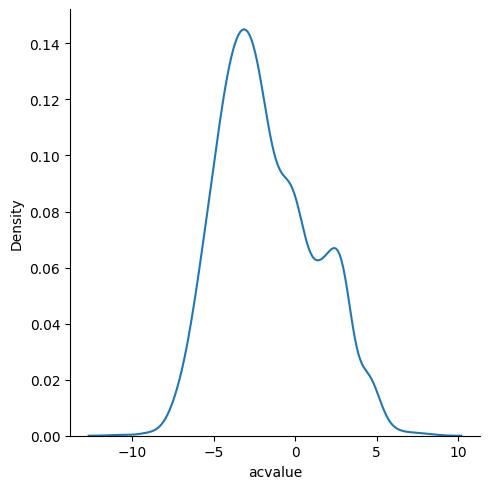

In [27]:
#plot the acvalue to see how it spreads out
sns.displot(np.log(df['acvalue']), kind = 'kde')

### Train the model by dividing it into 90% train group and 10% test group

In [28]:
train_df = df.drop(columns=['smiles', 'mol', 'acvalue'])
y = df['acvalue'].values

print(train_df.columns)

#split the data into train and test group

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1, random_state=1)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'tpsa', 'mol_w',
       'num_valence_electrons', 'num_heteroatoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')


In [29]:
#Train the model
ridge = RidgeCV(cv=10)
ridge.fit(X_train, y_train)


RidgeCV(cv=10)

# Plot the result values with the given value, determind the error

In [30]:
def evaluation(model, X_test, y_test, outlier):
    colorL = []
    prediction = model.predict(X_test)
    for i in range (len(y_test)):
      if abs(prediction[i]-y_test[i]) >= 2:
        outlier.append(i)
        colorL.append('grey')
      else:
        colorL.append('red')
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction, squared = True)
    plt.figure(figsize=(15, 10))
    plt.plot([y_test.min(),y_test.max()],[model.predict(X_test).min(),model.predict(X_test).max()])
    plt.scatter(y_test, prediction, color = colorL)
    plt.legend()
    plt.ylabel('Predicted value')
    plt.xlabel('Actual value')
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))

    plt.show()

    print('MAE score:', round(mae, 4))
    print('RMSE score:', round(mse,4))
    #return outlier

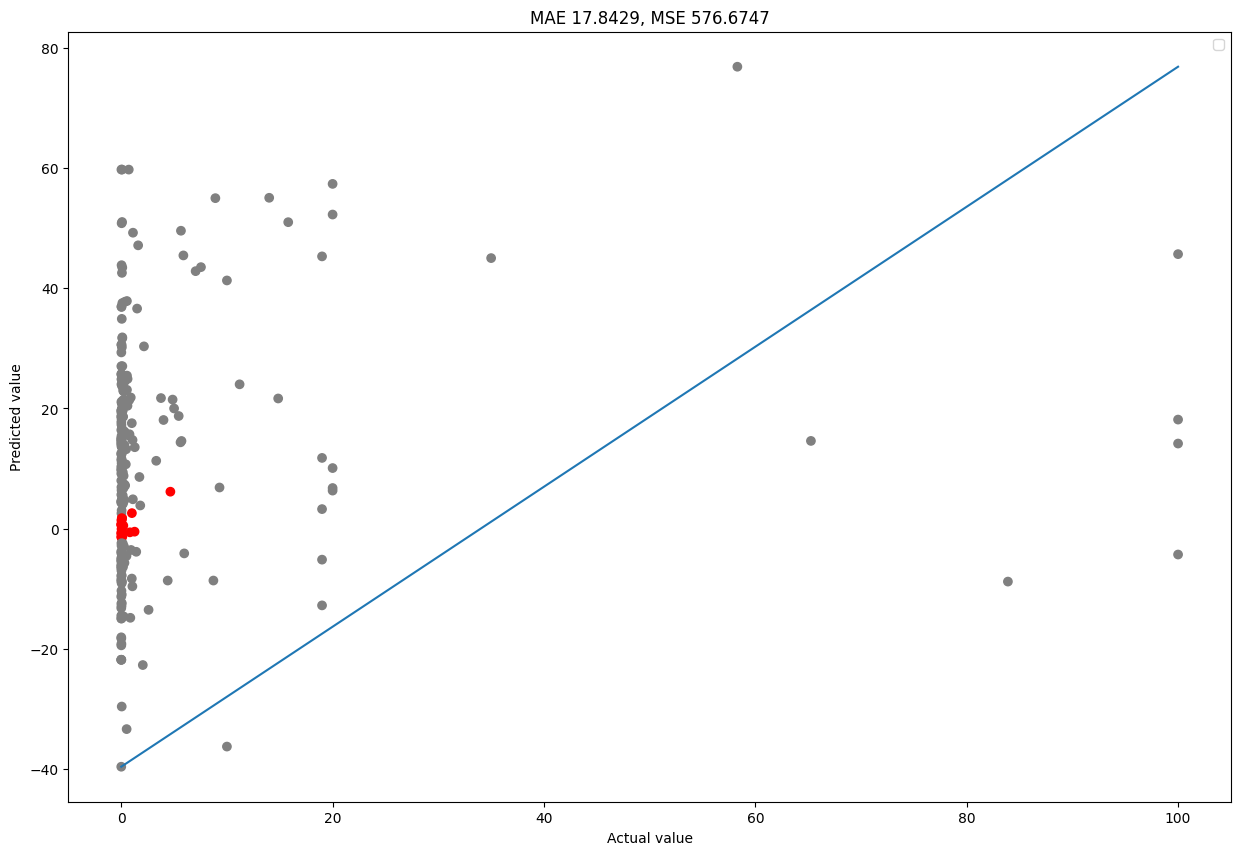

MAE score: 17.8429
RMSE score: 576.6747


In [31]:
#Evaluate results and plot predictions
evaluation(ridge, X_test, y_test, [])

# Import the mol2vec model that automatically generate top 300 descriptors for each molecule

In [32]:
model = word2vec.Word2Vec.load('/content/drive/MyDrive/model_300dim.pkl')

In [33]:
#generates molecular embeddings with the help of the trained model
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """
    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [34]:
#constructs a so-called 'molecular sentence' with desired Morgan fingerprints' radius
#Constructing sentences
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
df['mol2vec'] = [DfVec(x) for x in sentences2vec(df['sentence'], model, unseen='UNK')]

df.columns.values

array(['acvalue', 'smiles', 'mol', 'num_of_atoms', 'num_of_heavy_atoms',
       'tpsa', 'mol_w', 'num_valence_electrons', 'num_heteroatoms',
       'num_of_C_atoms', 'num_of_O_atoms', 'num_of_N_atoms',
       'num_of_Cl_atoms', 'sentence', 'mol2vec'], dtype=object)

In [35]:
df

,acvalue,smiles,mol,num_of_atoms,num_of_heavy_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,sentence,mol2vec
0,210.000000,C1=CC(=CN=C1)C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x7929cadacba0>,15,9,55.98,122.048013,46,3,6,1,2,0,"(3218693969, 2392445291, 3218693969, 113013457...","(300,) dimensional vector"
1,0.390000,C1=CC2=C(C=CNC2=O)C(=C1)O,<rdkit.Chem.rdchem.Mol object at 0x7929cadaccf0>,19,12,53.09,161.047678,60,3,9,2,1,0,"(3218693969, 2392445291, 3218693969, 113013457...","(300,) dimensional vector"
2,20.207727,C1=CC(=CC(=C1)N)C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x7929cadacd60>,18,10,69.11,136.063663,52,3,7,1,2,0,"(3218693969, 2392445291, 3218693969, 113013457...","(300,) dimensional vector"
3,0.103000,C1=CC2=C(C=CC3=C2C(=C1)C(=O)NC3=O)N,<rdkit.Chem.rdchem.Mol object at 0x7929cadacdd0>,24,16,72.19,212.058577,78,4,12,2,2,0,"(3218693969, 2392445291, 3218693969, 113013457...","(300,) dimensional vector"
4,0.390000,C1=CC=C2C(=C1)C3=CC=CC=C3NC2=O,<rdkit.Chem.rdchem.Mol object at 0x7929cadace40>,24,15,32.86,195.068414,72,2,13,1,1,0,"(3218693969, 2392445291, 3218693969, 239244529...","(300,) dimensional vector"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,0.009800,CC1(CC1)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC(=C5)...,<rdkit.Chem.rdchem.Mol object at 0x7929cadef1b0>,39,24,77.56,326.117904,122,7,17,2,4,0,"(2246728737, 2199122054, 2976816164, 256916257...","(300,) dimensional vector"
2406,186.000000,COC1=C(C(=C(C(=C1)/C=N/NC(=S)NCCCN2CCOCC2)Br)B...,<rdkit.Chem.rdchem.Mol object at 0x7929cadef220>,51,27,67.35,521.993586,150,10,17,3,4,0,"(2246728737, 1024462557, 864674487, 2076190208...","(300,) dimensional vector"
2407,0.017900,CC1(C(C1(C)C)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC...,<rdkit.Chem.rdchem.Mol object at 0x7929cadef290>,48,27,77.56,368.164854,140,7,20,2,4,0,"(2246728737, 2199122054, 2976816164, 337148799...","(300,) dimensional vector"
2408,0.002640,CN1C(=O)CCC(C1=O)N2C(=O)C3=C(C2=O)C(=CC=C3)NCC...,<rdkit.Chem.rdchem.Mol object at 0x7929cadef300>,120,65,202.26,890.412689,342,17,48,8,8,0,"(2246728737, 241489735, 2092489639, 2975116251...","(300,) dimensional vector"


## Loading the mordred extension that generate molecular descriptors for molecules

In [36]:
calc = Calculator(descriptors, ignore_3D=False)
ds = calc.pandas(df['mol'])

100%|██████████| 2410/2410 [09:21<00:00,  4.29it/s]


In [37]:
ds

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,6.542301,6.236096,0,0,11.189957,2.193993,4.387987,11.189957,1.243329,3.089765,...,8.590258,37.289972,122.048013,8.136534,88,9,40.0,43.0,3.472222,2.111111
1,9.289847,8.158454,0,0,15.561028,2.390257,4.780514,15.561028,1.296752,3.426928,...,9.463198,43.254272,161.047678,8.476194,176,18,62.0,73.0,3.944444,2.666667
2,7.358797,6.989468,0,0,11.908678,2.242838,4.485676,11.908678,1.190868,3.197246,...,8.830689,39.160939,136.063663,7.559092,117,11,46.0,50.0,4.333333,2.277778
3,12.813451,10.533151,0,0,20.822773,2.519885,5.039771,20.822773,1.301423,3.739956,...,10.047891,49.488029,212.058577,8.835774,367,30,90.0,111.0,5.277778,3.416667
4,11.968445,9.678570,0,0,20.261595,2.46601,4.93202,20.261595,1.350773,3.672957,...,9.834941,47.806246,195.068414,8.127851,322,25,82.0,99.0,3.805556,3.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,19.941388,15.505815,0,0,31.814124,2.595233,5.019513,31.814124,1.325589,4.193696,...,10.535477,80.396765,326.117904,8.361998,1174,48,146.0,184.0,7.423611,4.861111
2406,19.965399,15.890557,0,1,34.403561,2.408162,4.816323,34.403561,1.274206,4.184253,...,9.943525,61.380711,521.993586,10.235168,2352,39,128.0,145.0,9.527778,6.361111
2407,22.342680,17.944337,0,0,34.185008,2.694742,5.114993,34.185008,1.266111,4.309112,...,10.814424,85.976761,368.164854,7.670101,1663,54,166.0,213.0,10.097222,5.368056
2408,50.610998,31.599056,0,0,85.002039,2.556828,4.992923,85.002039,1.307724,5.095533,...,11.105604,119.170515,890.412689,7.420106,30942,111,340.0,403.0,20.694444,14.388889


In [38]:
df_with_modred=pd.concat([df, ds], axis = 1)

In [39]:
df_with_modred

,acvalue,smiles,mol,num_of_atoms,num_of_heavy_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_C_atoms,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,210.000000,C1=CC(=CN=C1)C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x7929cadacba0>,15,9,55.98,122.048013,46,3,6,...,8.590258,37.289972,122.048013,8.136534,88,9,40.0,43.0,3.472222,2.111111
1,0.390000,C1=CC2=C(C=CNC2=O)C(=C1)O,<rdkit.Chem.rdchem.Mol object at 0x7929cadaccf0>,19,12,53.09,161.047678,60,3,9,...,9.463198,43.254272,161.047678,8.476194,176,18,62.0,73.0,3.944444,2.666667
2,20.207727,C1=CC(=CC(=C1)N)C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x7929cadacd60>,18,10,69.11,136.063663,52,3,7,...,8.830689,39.160939,136.063663,7.559092,117,11,46.0,50.0,4.333333,2.277778
3,0.103000,C1=CC2=C(C=CC3=C2C(=C1)C(=O)NC3=O)N,<rdkit.Chem.rdchem.Mol object at 0x7929cadacdd0>,24,16,72.19,212.058577,78,4,12,...,10.047891,49.488029,212.058577,8.835774,367,30,90.0,111.0,5.277778,3.416667
4,0.390000,C1=CC=C2C(=C1)C3=CC=CC=C3NC2=O,<rdkit.Chem.rdchem.Mol object at 0x7929cadace40>,24,15,32.86,195.068414,72,2,13,...,9.834941,47.806246,195.068414,8.127851,322,25,82.0,99.0,3.805556,3.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,0.009800,CC1(CC1)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC(=C5)...,<rdkit.Chem.rdchem.Mol object at 0x7929cadef1b0>,39,24,77.56,326.117904,122,7,17,...,10.535477,80.396765,326.117904,8.361998,1174,48,146.0,184.0,7.423611,4.861111
2406,186.000000,COC1=C(C(=C(C(=C1)/C=N/NC(=S)NCCCN2CCOCC2)Br)B...,<rdkit.Chem.rdchem.Mol object at 0x7929cadef220>,51,27,67.35,521.993586,150,10,17,...,9.943525,61.380711,521.993586,10.235168,2352,39,128.0,145.0,9.527778,6.361111
2407,0.017900,CC1(C(C1(C)C)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC...,<rdkit.Chem.rdchem.Mol object at 0x7929cadef290>,48,27,77.56,368.164854,140,7,20,...,10.814424,85.976761,368.164854,7.670101,1663,54,166.0,213.0,10.097222,5.368056
2408,0.002640,CN1C(=O)CCC(C1=O)N2C(=O)C3=C(C2=O)C(=CC=C3)NCC...,<rdkit.Chem.rdchem.Mol object at 0x7929cadef300>,120,65,202.26,890.412689,342,17,48,...,11.105604,119.170515,890.412689,7.420106,30942,111,340.0,403.0,20.694444,14.388889


In [40]:
df_with_modred.columns

Index(['acvalue', 'smiles', 'mol', 'num_of_atoms', 'num_of_heavy_atoms',
       'tpsa', 'mol_w', 'num_valence_electrons', 'num_heteroatoms',
       'num_of_C_atoms',
       ...
       'SRW10', 'TSRW10', 'MW', 'AMW', 'WPath', 'WPol', 'Zagreb1', 'Zagreb2',
       'mZagreb1', 'mZagreb2'],
      dtype='object', length=1841)

In [41]:
df_addmol2vec = df_with_modred
df_mol2vec = pd.DataFrame(np.array([x.vec for x in df['mol2vec']]))
df_addmol2vec = df_addmol2vec.join(df_mol2vec)

In [42]:
df_addmol2vec_na = df_addmol2vec.dropna()
df_addmol2vec_na.columns

Index([              'acvalue',                'smiles',
                         'mol',          'num_of_atoms',
          'num_of_heavy_atoms',                  'tpsa',
                       'mol_w', 'num_valence_electrons',
             'num_heteroatoms',        'num_of_C_atoms',
       ...
                           290,                     291,
                           292,                     293,
                           294,                     295,
                           296,                     297,
                           298,                     299],
      dtype='object', length=2141)

In [43]:
target=np.log(df_addmol2vec_na['acvalue'])
y = target.values
df_addmol2vec_train_with_mol = df_addmol2vec_na.drop(columns=['smiles', 'acvalue', 'sentence', 'mol2vec'])
df_addmol2vec_train = df_addmol2vec_na.drop(columns=['smiles', 'acvalue','mol','sentence', 'mol2vec'])

In [44]:
df_addmol2vec_train

,num_of_atoms,num_of_heavy_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,...,290,291,292,293,294,295,296,297,298,299
0,15,9,55.98,122.048013,46,3,6,1,2,0,...,0.496833,4.682097,2.673193,2.297762,-0.156407,1.632334,-3.253575,-6.839620,-5.285969,2.577614
1,19,12,53.09,161.047678,60,3,9,2,1,0,...,-0.559654,5.906354,2.206685,2.195790,-0.359730,0.723147,-4.512251,-7.322798,-6.297378,4.889225
2,18,10,69.11,136.063663,52,3,7,1,2,0,...,0.654338,5.454709,2.439177,3.171859,-0.434880,2.199030,-4.207020,-8.507815,-6.412305,3.524693
3,24,16,72.19,212.058577,78,4,12,2,2,0,...,0.483198,8.531787,3.069773,2.459901,-2.876506,0.099693,-5.541238,-9.024189,-9.307432,4.313900
4,24,15,32.86,195.068414,72,2,13,1,1,0,...,-0.228617,7.730791,3.215951,2.361279,0.354392,0.880099,-5.283615,-9.185725,-7.875863,5.900506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,39,24,77.56,326.117904,122,7,17,2,4,0,...,-0.883872,12.782725,0.216207,2.335772,-2.549765,0.967977,-10.300495,-16.467113,-13.409909,6.623158
2406,51,27,67.35,521.993586,150,10,17,3,4,0,...,-0.006396,12.901438,1.123122,6.023323,-1.712801,4.760748,-17.277304,-25.747587,-13.949639,9.143828
2407,48,27,77.56,368.164854,140,7,20,2,4,0,...,-0.803377,13.593388,-0.193917,5.135426,-1.863276,0.785479,-12.833200,-21.221037,-16.103769,9.376853
2408,120,65,202.26,890.412689,342,17,48,8,8,0,...,-0.246848,32.639996,5.101664,16.544388,-3.095066,9.413106,-27.701599,-54.847622,-39.527359,23.122040


### Dropping columns with data that is not able to be processed by ridge regressiong and turn datas with type float and float32 to float64

In [45]:
for i in df_addmol2vec_train.columns:
  if type(df_addmol2vec_train[i][10])==str:
    df_addmol2vec_train = df_addmol2vec_train.drop(columns=i)
    continue
  if type(df_addmol2vec_train[i][10]) == 'float' or type(df_addmol2vec_train[i][0]) == 'float32' or type(df_addmol2vec_train[i][10]) == 'int64':
    df_addmol2vec_train[i]= df_addmol2vec_train[i].astype(np.float64)
    continue
  if df_addmol2vec_train[i].isnull().values.any():
    df_addmol2vec_train = df_addmol2vec_train.drop(columns=i)
    continue

In [47]:
df_addmol2vec_train=df_addmol2vec_train.drop(columns='AATS7se')

In [46]:
#make sure there is not void value in the df
df_addmol2vec_train.isnull().sum().sum()

0

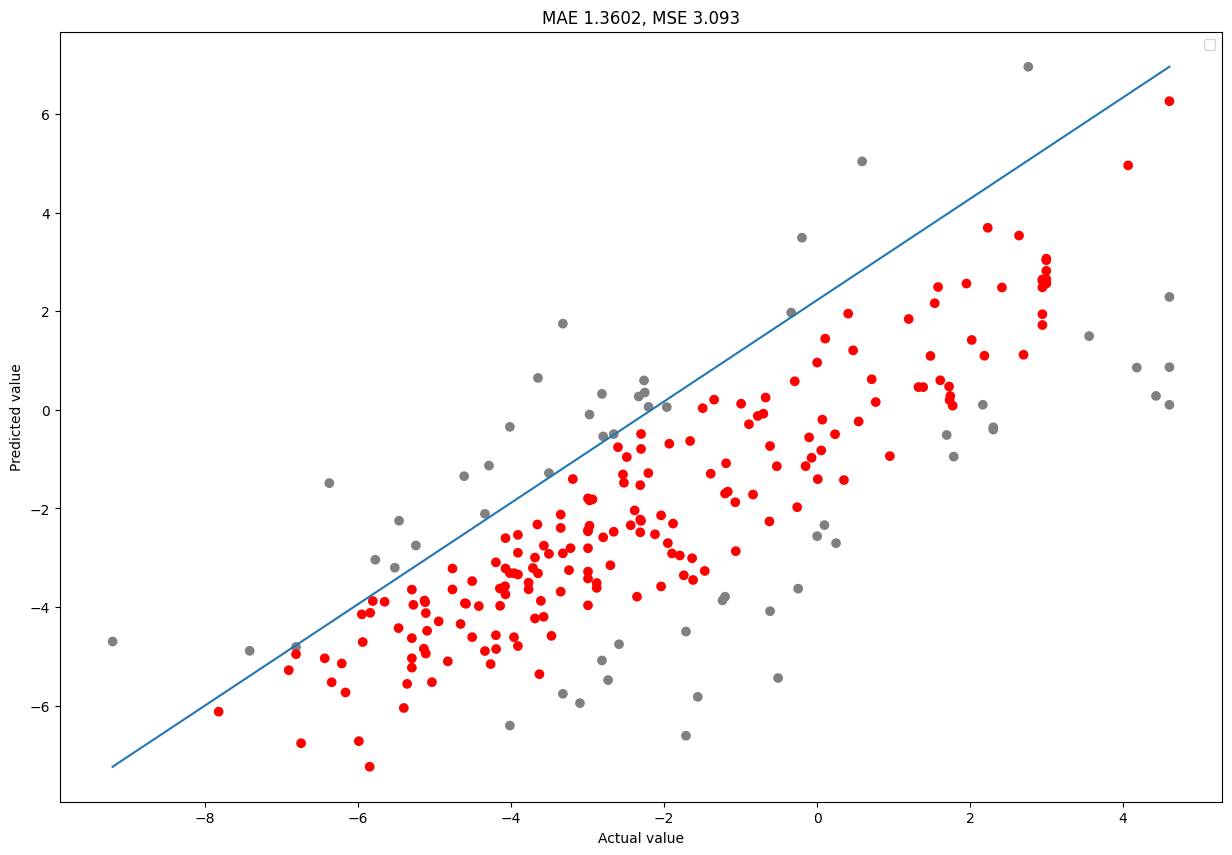

MAE score: 1.3602
RMSE score: 3.093


In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_addmol2vec_train, y, test_size=.1, random_state=1)
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
evaluation(ridge, X_test, y_test,[])

In [50]:
info = {}
List = []
for i in df_addmol2vec_train_with_mol['mol']:
  fp = AllChem.GetMorganFingerprintAsBitVect(i, useChirality=True, radius=2, nBits = 2048, bitInfo=info)
  List.append(np.array(fp))

In [51]:
names = []
for i in range (2048):
  names.append(str(i))

In [52]:
df_fingerprint = pd.DataFrame(data=List, columns = names)

In [53]:
len(df_fingerprint)

2410

In [54]:
df_mol2vec_fingerprint = df_addmol2vec_train.reset_index().merge(df_fingerprint.reset_index(), left_index=True, right_index=True, how='left')


In [56]:
df_mol2vec_fingerprint=df_mol2vec_fingerprint.drop(columns=["index_x", "Unnamed: 0"])

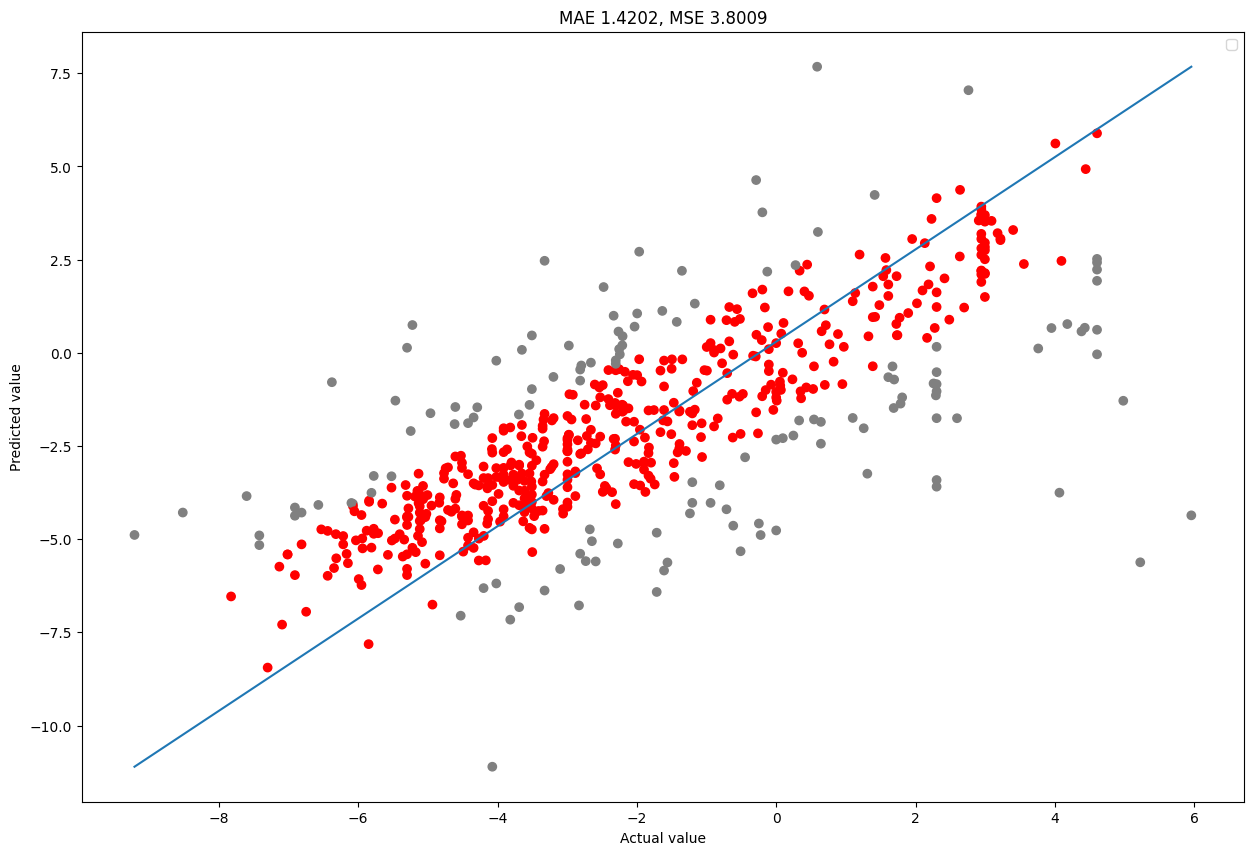

MAE score: 1.4202
RMSE score: 3.8009


In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_addmol2vec_train, y, test_size=.25, random_state=1)
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
evaluation(ridge, X_test, y_test, [])

## Random Forest Regressor

In [58]:
 # create regressor object
X_train, X_test, y_train, y_test = train_test_split(df_addmol2vec_train, y, test_size=.25, random_state=1)
RFregressor = RandomForestRegressor(n_estimators = 1000, random_state = 1)
# fit the regressor with x and y data
RFregressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=1)

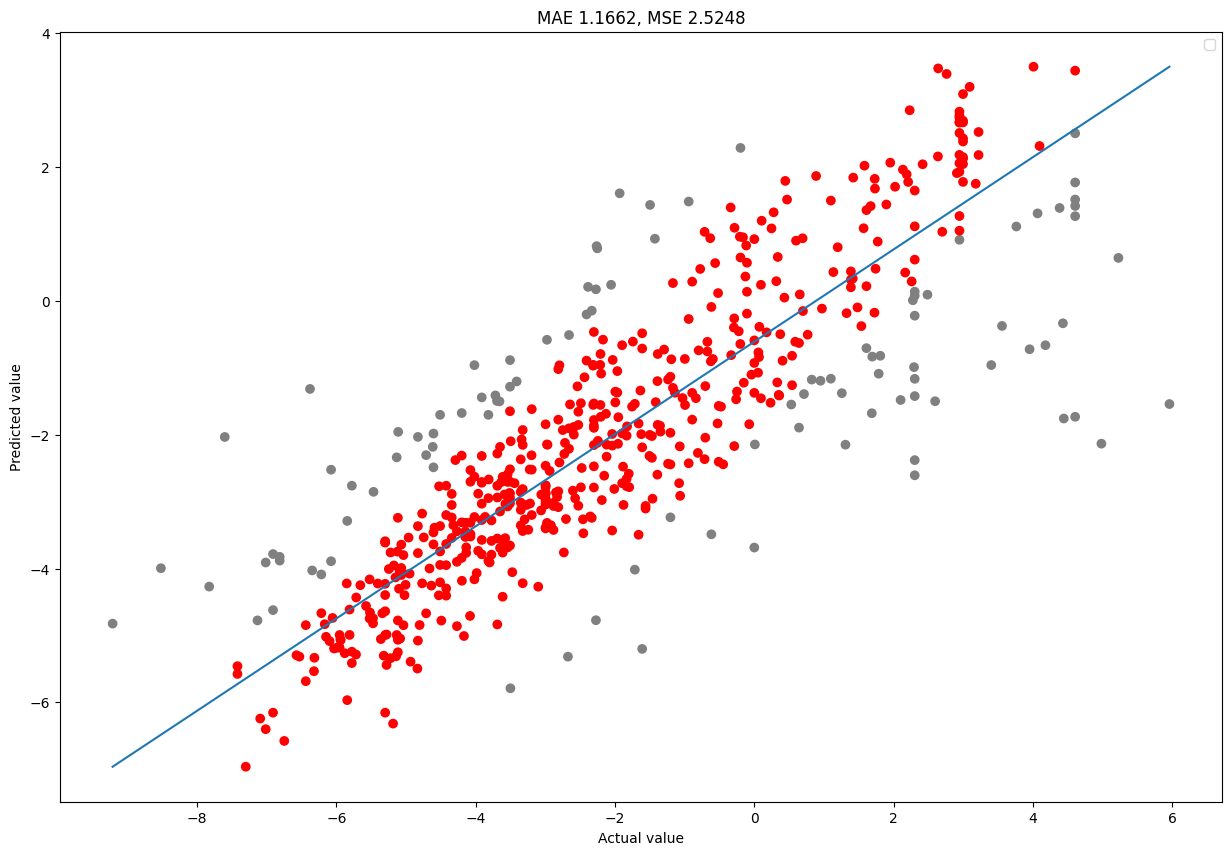

MAE score: 1.1662
RMSE score: 2.5248


In [59]:
evaluation(RFregressor, X_test, y_test, [])

## Compress the model into a pickle package

In [60]:
import pickle

In [61]:
filename = 'finalized_RF_model_2.pkl'
pickle.dump(RFregressor, open(filename, 'wb'))
pickled_model = pickle.load(open('finalized_RF_model_2.pkl', 'rb'))

## Principal component analysis

In [62]:
name_pca = []
for i in range (1, 3):
  name_pca.append('component'+str(i))

In [63]:
from sklearn.preprocessing import StandardScaler
pca_dt = StandardScaler().fit_transform(df_mol2vec_fingerprint)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pca_dt)
principalDf = pd.DataFrame(data = principalComponents
             , columns = name_pca)
principalDf_final_human = pd.concat([principalDf, df[['smiles']]], axis = 1)

In [64]:
principalDf_final_human

,component1,component2,smiles
0,-54.420065,-13.489709,C1=CC(=CN=C1)C(=O)N
1,-47.665249,-3.199205,C1=CC2=C(C=CNC2=O)C(=C1)O
2,-50.743218,-14.702545,C1=CC(=CC(=C1)N)C(=O)N
3,-38.881087,5.346952,C1=CC2=C(C=CC3=C2C(=C1)C(=O)NC3=O)N
4,-37.684270,-3.976675,C1=CC=C2C(=C1)C3=CC=CC=C3NC2=O
...,...,...,...
2405,-10.482565,9.721852,CC1(CC1)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC(=C5)...
2406,5.413253,-5.902432,COC1=C(C(=C(C(=C1)/C=N/NC(=S)NCCCN2CCOCC2)Br)B...
2407,7.973179,4.556955,CC1(C(C1(C)C)C(=O)N2CC3=C4C(=NNC(=O)C5=C4C(=CC...
2408,108.663136,6.967232,CN1C(=O)CCC(C1=O)N2C(=O)C3=C(C2=O)C(=CC=C3)NCC...


In [65]:
principalDf_final_human=principalDf_final_human.drop(columns='smiles')

In [66]:
outlier=[13,
 14,
 15,
 21,
 28,
 31,
 36,
 38,
 39,
 44,
 50,
 55,
 69,
 70,
 71,
 73,
 83,
 86,
 87,
 90,
 110,
 120,
 129,
 138,
 147,
 151,
 160,
 161,
 163,
 165,
 176,
 181,
 192,
 198,
 208,
 211,
 212,
 215,
 220,
 225,
 239,
 243,
 246,
 260,
 263,
 264,
 267,
 270,
 271,
 276,
 278,
 294,
 296,
 301,
 316,
 319,
 339,
 340,
 342,
 350,
 352,
 359,
 362,
 363,
 367,
 368,
 371,
 372,
 378,
 383,
 391,
 395,
 398,
 414,
 419,
 423,
 427,
 431,
 436,
 451,
 452,
 455,
 456,
 460,
 463,
 470,
 477,
 486,
 501,
 507,
 521,
 532,
 539,
 542,
 544,
 548,
 550,
 554,
 563,
 569,
 570,
 575]

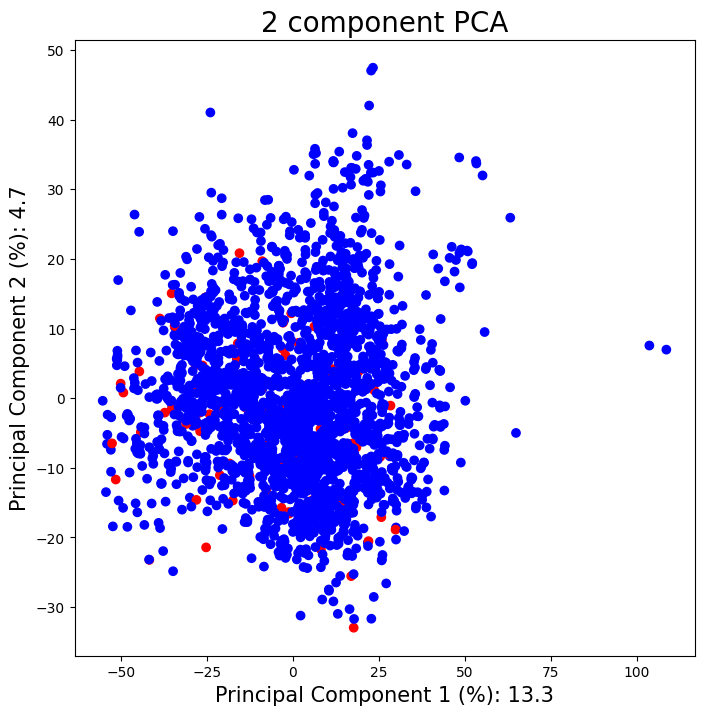

In [67]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1 (%): ' + str(round(pca.explained_variance_ratio_[0]*100,1)), fontsize = 15)
ax.set_ylabel('Principal Component 2 (%): ' + str(round(pca.explained_variance_ratio_[1]*100,1)), fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
colorList = []
for i in range (len(principalDf_final_human['component1'])):
  if i in outlier:
    colorList.append('red')
  else:
    colorList.append('blue')
plt.scatter(principalDf_final_human['component1'],
            principalDf_final_human['component2'], color = colorList)



In [68]:
sum(pca.explained_variance_ratio_)

0.18004527128120784

# Import & Generate Features for Drug Data

In [69]:
Pdf= pd.read_csv('/content/drive/MyDrive/Yvonne/dt/Prestwick Chemical Library_Ver20.csv')

Pdf

,Plate Number / Position Number,Prestw number,Chemical name,Name synonym,CAS number,Mol Weight,Formula,Solubility (from literature),Approved by,Launching date,...,Target type,Target name,Target mechanism,Side effects,CNS (from literature),Rule of 5 violation,Melting point,Trade tariff,IUPAC name,smiles code
0,01A02,Prestw-1,Azaguanine-8,NaN,134-58-7,152.12,C4H4N6O,DMSO,No,NaN,...,Enzyme,Purine antimetabolite,NaN,NaN,NaN,0.0,NaN,3004900000,"5-Amino-3H-[1,2,3]triazolo[4,5-d]pyrimidin-7-ol",c12/N=C(\NC(c1nn[nH]2)=O)/N
1,01A03,Prestw-2,Allantoin,NaN,97-59-6,158.12,C4H6N4O3,"H2O, EtOH",EMA,1987,...,GPCR,Vasopressin V2 receptor,antagonist,Irritation,NaN,NaN,238,3004900000,"(2,5-Dioxo-4-imidazolidinyl) urea",N1C(NC(C1=O)NC(=O)N)=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Burning,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Hypersensitivity reactions,NaN,NaN,NaN,NaN,NaN,NaN
4,01A04,Prestw-3,Acetazolamide,NaN,59-66-5,222.25,C4H6N4O3S2,EtOH/H2O:50/50,FDA,1953,...,Enzyme,"Carbonic anhydrase I, II, IV, XII",inhibitor,Paresthesia,NaN,0.0,258 - 259,3004900000,"N-(5-sulfamoyl-1,3,4-thiadiazol-2-yl)acetamide",c1(S(=O)(=O)N)sc(nn1)NC(=O)C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5140,19H10,Prestw-2093,Hippuric acid,NaN,495-69-2,179.18,C9H9NO3,NaN,FDA,1976,...,NaN,Solute carrier family 22,inhibitor,Irritation of the bladder,NaN,NaN,NaN,NaN,2-benzamidoacetic acid,OC(=O)CNC(=O)c1ccccc1
5141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Vomiting,NaN,NaN,NaN,NaN,NaN,NaN
5142,19H11,Prestw-2096,Riboflavine,Vitamin B2,83-88-5,376.37,C17H20N4O6,NaN,"FDA, EMA, JAN",1953,...,Coenzyme,Flavin mononucleotide,NaN,Yellow urine,NaN,NaN,NaN,NaN,"7,8-dimethyl-10-[(2S,3S,4R)-2,3,4,5-tetrahydro...",Cc1cc2N=C3C(=O)NC(=O)N=C3N(C[C@H](O)[C@H](O)[C...


In [70]:
PDF=Pdf[['smiles code']]

In [71]:
PDF.head()

,smiles code
0,c12/N=C(\NC(c1nn[nH]2)=O)/N
1,N1C(NC(C1=O)NC(=O)N)=O
2,NaN
3,NaN
4,c1(S(=O)(=O)N)sc(nn1)NC(=O)C


In [72]:
#drop the molecules whose SMILES is not found
PDF=PDF.dropna()

PDF

,smiles code
0,c12/N=C(\NC(c1nn[nH]2)=O)/N
1,N1C(NC(C1=O)NC(=O)N)=O
4,c1(S(=O)(=O)N)sc(nn1)NC(=O)C
8,C(NC(=N)N)(=N)N(C)C
12,[N+]1(C(c2c(cc(c(c2)OC)OC)CC1)Cc1cc(c(cc1)OC)O...
...,...
5134,CCC(NC(C)C)C(O)c1ccc(O)c2NC(=O)C=Cc12
5137,COc1cc(ccc1\N=N\c2ccc3c(cc(c(N)c3c2O)S(=O)(=O)...
5138,CCOC(=O)C(C)(N)Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(...
5140,OC(=O)CNC(=O)c1ccccc1


In [73]:
#reset the index after dropping nan values
Pdf2 = PDF.reset_index()

Pdf2

,index,smiles code
0,0,c12/N=C(\NC(c1nn[nH]2)=O)/N
1,1,N1C(NC(C1=O)NC(=O)N)=O
2,4,c1(S(=O)(=O)N)sc(nn1)NC(=O)C
3,8,C(NC(=N)N)(=N)N(C)C
4,12,[N+]1(C(c2c(cc(c(c2)OC)OC)CC1)Cc1cc(c(cc1)OC)O...
...,...,...
1515,5134,CCC(NC(C)C)C(O)c1ccc(O)c2NC(=O)C=Cc12
1516,5137,COc1cc(ccc1\N=N\c2ccc3c(cc(c(N)c3c2O)S(=O)(=O)...
1517,5138,CCOC(=O)C(C)(N)Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(...
1518,5140,OC(=O)CNC(=O)c1ccccc1


In [74]:
PDF=Pdf2

In [75]:
Pdf = PDF.drop(columns='index')

In [77]:
#Method transforms smiles strings to mol rdkit object
Pdf['mol'] = Pdf['smiles code'].apply(lambda x: Chem.MolFromSmiles(x))

[08:05:55] SMILES Parse Error: syntax error while parsing: C1(C(C(C(C(O1)C)OC1CC(C(C(O1)C)O)(O)C)N(C)C)O)O[C@@H]1[C@H]([C@@H](CC(O[C@@H](C/C=C/C=C/[C@H](OC2OC(C(CC2)N(C)C)C)[C@@H](C[C@@H]1CC=O)C)C)=O)O['R'])OC
[08:05:55] SMILES Parse Error: Failed parsing SMILES 'C1(C(C(C(C(O1)C)OC1CC(C(C(O1)C)O)(O)C)N(C)C)O)O[C@@H]1[C@H]([C@@H](CC(O[C@@H](C/C=C/C=C/[C@H](OC2OC(C(CC2)N(C)C)C)[C@@H](C[C@@H]1CC=O)C)C)=O)O['R'])OC' for input: 'C1(C(C(C(C(O1)C)OC1CC(C(C(O1)C)O)(O)C)N(C)C)O)O[C@@H]1[C@H]([C@@H](CC(O[C@@H](C/C=C/C=C/[C@H](OC2OC(C(CC2)N(C)C)C)[C@@H](C[C@@H]1CC=O)C)C)=O)O['R'])OC'
[08:05:55] SMILES Parse Error: syntax error while parsing: CC(C)C[C@@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(=O)N[C@@H](C)C(=O)N[C@H](C(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@H](C(C)C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@H](CC(C)C)C(=O)N[C@@H](Cc3c[nH]c4ccccc34)C(=O)N[C@H](CC(C)C)C(=O)N[C@@H](Cc5c[nH]c6...
[08:05:55] SMILES Parse Error: Failed parsing SMILES 'CC(C)C[C@@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@@H](NC=O)

In [78]:
Pdf=Pdf.dropna()

Pdf

,smiles code,mol
0,c12/N=C(\NC(c1nn[nH]2)=O)/N,<rdkit.Chem.rdchem.Mol object at 0x7929a4319a80>
1,N1C(NC(C1=O)NC(=O)N)=O,<rdkit.Chem.rdchem.Mol object at 0x7929a43194d0>
2,c1(S(=O)(=O)N)sc(nn1)NC(=O)C,<rdkit.Chem.rdchem.Mol object at 0x7929a4319620>
3,C(NC(=N)N)(=N)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x7929a43192a0>
4,[N+]1(C(c2c(cc(c(c2)OC)OC)CC1)Cc1cc(c(cc1)OC)O...,<rdkit.Chem.rdchem.Mol object at 0x7929a4319850>
...,...,...
1515,CCC(NC(C)C)C(O)c1ccc(O)c2NC(=O)C=Cc12,<rdkit.Chem.rdchem.Mol object at 0x7929a4366ea0>
1516,COc1cc(ccc1\N=N\c2ccc3c(cc(c(N)c3c2O)S(=O)(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7929a4366f10>
1517,CCOC(=O)C(C)(N)Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(...,<rdkit.Chem.rdchem.Mol object at 0x7929a4366f80>
1518,OC(=O)CNC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7929a4366ff0>


## Add Molecular Discriptors for drugs

1. number of atoms
2. number of heavy atoms
3. tpsa
4. molecular weight
5. number of valence electrons
6. number of heteroatoms

In [79]:
#since H atoms is not included in the smiles, we need to add the H back
#df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
Pdf['num_of_atoms'] = Pdf['mol'].apply(lambda x: x.GetNumAtoms())
Pdf['num_of_heavy_atoms'] = Pdf['mol'].apply(lambda x: x.GetNumHeavyAtoms())

Pdf['tpsa'] = Pdf['mol'].apply(lambda x: Descriptors.TPSA(x))
Pdf['mol_w'] = Pdf['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
Pdf['num_valence_electrons'] = Pdf['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
Pdf['num_heteroatoms'] = Pdf['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x)) #non-carbon

### Get the substructure of atoms, number of each common elements

In [80]:
def number_of_atoms(atom_list, df):
    for i in atom_list:
        Pdf['num_of_{}_atoms'.format(i)] = Pdf['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], Pdf)

### Import the mol2vec model that automatically generate top 300 descriptors for each drug

In [81]:
#constructs a so-called 'molecular sentence' with desired Morgan fingerprints' radius
#Constructing sentences
Pdf['sentence'] = Pdf.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
Pdf['mol2vec'] = [DfVec(x) for x in sentences2vec(Pdf['sentence'], model, unseen='UNK')]

In [82]:
Pdf

,smiles code,mol,num_of_atoms,num_of_heavy_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,sentence,mol2vec
0,c12/N=C(\NC(c1nn[nH]2)=O)/N,<rdkit.Chem.rdchem.Mol object at 0x7929a4319a80>,11,11,113.34,152.044659,56,7,4,1,6,0,"(3217380708, 2355446912, 2041434490, 110190777...","(300,) dimensional vector"
1,N1C(NC(C1=O)NC(=O)N)=O,<rdkit.Chem.rdchem.Mol object at 0x7929a43194d0>,11,11,113.32,158.043990,60,7,4,3,4,0,"(2132511834, 2296493092, 3217380708, 325504607...","(300,) dimensional vector"
2,c1(S(=O)(=O)N)sc(nn1)NC(=O)C,<rdkit.Chem.rdchem.Mol object at 0x7929a4319620>,13,13,115.04,221.988132,72,9,4,3,4,0,"(3217380708, 3058108901, 999334238, 3532053313...","(300,) dimensional vector"
3,C(NC(=N)N)(=N)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x7929a43192a0>,9,9,88.99,129.101445,52,5,4,0,5,0,"(2246699815, 2669803748, 847961216, 828869727,...","(300,) dimensional vector"
4,[N+]1(C(c2c(cc(c(c2)OC)OC)CC1)Cc1cc(c(cc1)OC)O...,<rdkit.Chem.rdchem.Mol object at 0x7929a4319850>,67,67,126.44,928.507429,364,14,53,12,2,0,"(2114539071, 2527120608, 2976033787, 495171958...","(300,) dimensional vector"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,CCC(NC(C)C)C(O)c1ccc(O)c2NC(=O)C=Cc12,<rdkit.Chem.rdchem.Mol object at 0x7929a4366ea0>,21,21,85.35,290.163043,114,5,16,3,2,0,"(2246728737, 3542456614, 2245384272, 150656359...","(300,) dimensional vector"
1516,COc1cc(ccc1\N=N\c2ccc3c(cc(c(N)c3c2O)S(=O)(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7929a4366f10>,60,60,389.20,900.015357,314,26,34,16,6,0,"(2246728737, 3975275337, 864674487, 2076190208...","(300,) dimensional vector"
1517,CCOC(=O)C(C)(N)Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(...,<rdkit.Chem.rdchem.Mol object at 0x7929a4366f80>,27,27,81.78,818.733650,146,9,18,4,1,0,"(2246728737, 3542456614, 2245384272, 399408866...","(300,) dimensional vector"
1518,OC(=O)CNC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7929a4366ff0>,13,13,66.40,179.058243,68,4,9,3,1,0,"(864662311, 1533864325, 2246699815, 4278941385...","(300,) dimensional vector"


### Loading the mordred extension that generate molecular descriptors for drugs

In [83]:
Pcalc = Calculator(descriptors, ignore_3D=False)
Pds = Pcalc.pandas(df['mol'])

100%|██████████| 2410/2410 [09:35<00:00,  4.18it/s]


In [84]:
Pdf_with_modred=pd.concat([Pdf, Pds], axis = 1)

In [85]:
Pdf_with_modred

,smiles code,mol,num_of_atoms,num_of_heavy_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_C_atoms,num_of_O_atoms,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,c12/N=C(\NC(c1nn[nH]2)=O)/N,<rdkit.Chem.rdchem.Mol object at 0x7929a4319a80>,11.0,11.0,113.34,152.044659,56.0,7.0,4.0,1.0,...,8.590258,37.289972,122.048013,8.136534,88,9,40.0,43.0,3.472222,2.111111
1,N1C(NC(C1=O)NC(=O)N)=O,<rdkit.Chem.rdchem.Mol object at 0x7929a43194d0>,11.0,11.0,113.32,158.043990,60.0,7.0,4.0,3.0,...,9.463198,43.254272,161.047678,8.476194,176,18,62.0,73.0,3.944444,2.666667
2,c1(S(=O)(=O)N)sc(nn1)NC(=O)C,<rdkit.Chem.rdchem.Mol object at 0x7929a4319620>,13.0,13.0,115.04,221.988132,72.0,9.0,4.0,3.0,...,8.830689,39.160939,136.063663,7.559092,117,11,46.0,50.0,4.333333,2.277778
3,C(NC(=N)N)(=N)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x7929a43192a0>,9.0,9.0,88.99,129.101445,52.0,5.0,4.0,0.0,...,10.047891,49.488029,212.058577,8.835774,367,30,90.0,111.0,5.277778,3.416667
4,[N+]1(C(c2c(cc(c(c2)OC)OC)CC1)Cc1cc(c(cc1)OC)O...,<rdkit.Chem.rdchem.Mol object at 0x7929a4319850>,67.0,67.0,126.44,928.507429,364.0,14.0,53.0,12.0,...,9.834941,47.806246,195.068414,8.127851,322,25,82.0,99.0,3.805556,3.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.535477,80.396765,326.117904,8.361998,1174,48,146.0,184.0,7.423611,4.861111
2406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.943525,61.380711,521.993586,10.235168,2352,39,128.0,145.0,9.527778,6.361111
2407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.814424,85.976761,368.164854,7.670101,1663,54,166.0,213.0,10.097222,5.368056
2408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.105604,119.170515,890.412689,7.420106,30942,111,340.0,403.0,20.694444,14.388889


In [86]:
Pdf_addmol2vec = Pdf_with_modred
Pdf_mol2vec = pd.DataFrame(np.array([x.vec for x in Pdf['mol2vec']]))
Pdf_addmol2vec = Pdf_addmol2vec.join(Pdf_mol2vec)

In [87]:
Pdf_addmol2vec_na = Pdf_addmol2vec.dropna()
Pdf_addmol2vec_na.columns

Index([          'smiles code',                   'mol',
                'num_of_atoms',    'num_of_heavy_atoms',
                        'tpsa',                 'mol_w',
       'num_valence_electrons',       'num_heteroatoms',
              'num_of_C_atoms',        'num_of_O_atoms',
       ...
                           290,                     291,
                           292,                     293,
                           294,                     295,
                           296,                     297,
                           298,                     299],
      dtype='object', length=2140)

In [128]:
#target=np.log(df_addmol2vec_na['acvalue'])
#y = target.values
Pdf_addmol2vec_train_with_mol = Pdf_addmol2vec_na.drop(columns=['sentence', 'mol2vec'])
Pdf_addmol2vec_train = Pdf_addmol2vec_na.drop(columns=['mol','sentence', 'mol2vec'])

In [134]:
Pdf_smile = Pdf_addmol2vec_train['smiles code']
Pdf_addmol2vec_train.drop(columns = ['smiles code'])
Pdf_addmol2vec_train_with_mol.drop(columns = ['smiles code'])

,mol,num_of_atoms,num_of_heavy_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,...,290,291,292,293,294,295,296,297,298,299
0,<rdkit.Chem.rdchem.Mol object at 0x7929a4319a80>,11.0,11.0,113.34,152.044659,56.0,7.0,4.0,1.0,6.0,...,-0.731568,3.558635,5.087549,-1.540653,-1.019928,-1.758661,-1.751484,-0.714202,-5.700473,1.027161
1,<rdkit.Chem.rdchem.Mol object at 0x7929a43194d0>,11.0,11.0,113.32,158.043990,60.0,7.0,4.0,3.0,4.0,...,1.614793,5.469296,2.425676,1.640512,-4.850060,-4.136834,-2.429466,-3.533143,-7.533617,-0.370427
2,<rdkit.Chem.rdchem.Mol object at 0x7929a4319620>,13.0,13.0,115.04,221.988132,72.0,9.0,4.0,3.0,4.0,...,0.499705,4.924769,4.754200,-1.341367,-4.610443,-0.341954,-4.746260,-2.387605,-6.020647,-1.522290
3,<rdkit.Chem.rdchem.Mol object at 0x7929a43192a0>,9.0,9.0,88.99,129.101445,52.0,5.0,4.0,0.0,5.0,...,1.018789,2.798827,5.331986,0.676119,-3.409892,1.953797,-2.917391,-3.327465,-7.683420,-0.578918
4,<rdkit.Chem.rdchem.Mol object at 0x7929a4319850>,67.0,67.0,126.44,928.507429,364.0,14.0,53.0,12.0,2.0,...,1.684525,27.947699,17.258112,-3.799146,-20.234804,-17.621675,-18.913860,-18.119314,-26.888573,-3.049874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,<rdkit.Chem.rdchem.Mol object at 0x7929a4366dc0>,34.0,34.0,128.03,481.130756,176.0,10.0,24.0,6.0,3.0,...,-0.945979,6.162346,9.244426,1.958476,-5.526976,-3.699253,-2.096386,-5.321037,-8.846354,0.320659
1514,<rdkit.Chem.rdchem.Mol object at 0x7929a4366e30>,30.0,30.0,71.55,417.226371,164.0,8.0,22.0,5.0,3.0,...,0.613897,23.926710,23.119207,-4.622244,-12.758946,-3.891364,-19.733692,-0.894498,-21.083542,0.678785
1515,<rdkit.Chem.rdchem.Mol object at 0x7929a4366ea0>,21.0,21.0,85.35,290.163043,114.0,5.0,16.0,3.0,2.0,...,2.476358,2.692306,8.788254,1.422255,-7.034523,-2.575714,-6.851965,-6.153033,-11.612686,-2.333706
1516,<rdkit.Chem.rdchem.Mol object at 0x7929a4366f10>,60.0,60.0,389.20,900.015357,314.0,26.0,34.0,16.0,6.0,...,-0.580573,5.079510,5.710309,2.117706,-3.892456,-0.963075,-0.811049,-3.308161,-5.956901,-0.941189


### Generate morgan fingerprints to help improve the model

In [90]:
info = {}
List = []
for i in Pdf_addmol2vec_train_with_mol['mol']:
  fp = AllChem.GetMorganFingerprintAsBitVect(i, useChirality=True, radius=2, nBits = 2048, bitInfo=info)
  List.append(np.array(fp))

In [91]:
names = []
for i in range (2048):
  names.append(str(i))

In [92]:
Pdf_fingerprint = pd.DataFrame(data=List, columns = names)

In [93]:
len(Pdf_fingerprint)

1516

In [94]:
Pdf_mol2vec_fingerprint = Pdf_addmol2vec_train.reset_index().merge(Pdf_fingerprint.reset_index(), left_index=True, right_index=True, how='left')

In [95]:
Pdf_mol2vec_fingerprint

,index_x,num_of_atoms,num_of_heavy_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,11.0,11.0,113.34,152.044659,56.0,7.0,4.0,1.0,6.0,...,0,0,0,0,0,0,0,0,0,0
1,1,11.0,11.0,113.32,158.043990,60.0,7.0,4.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
2,2,13.0,13.0,115.04,221.988132,72.0,9.0,4.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,3,9.0,9.0,88.99,129.101445,52.0,5.0,4.0,0.0,5.0,...,0,0,0,0,0,0,0,0,0,0
4,4,67.0,67.0,126.44,928.507429,364.0,14.0,53.0,12.0,2.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,1513,34.0,34.0,128.03,481.130756,176.0,10.0,24.0,6.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1512,1514,30.0,30.0,71.55,417.226371,164.0,8.0,22.0,5.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1513,1515,21.0,21.0,85.35,290.163043,114.0,5.0,16.0,3.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1514,1516,60.0,60.0,389.20,900.015357,314.0,26.0,34.0,16.0,6.0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
Pdf_mol2vec_fingerprint.isna().sum().sum()

0

In [ ]:
for i in Pdf_mol2vec_fingerprint.columns:
  print(i)
  if type(Pdf_mol2vec_fingerprint[i][0])==str:
    Pdf_mol2vec_fingerprint = Pdf_mol2vec_fingerprint.drop(columns=i)
    continue
  if Pdf_mol2vec_fingerprint[i].isnull().values.any():
    Pdf_mol2vec_fingerprint = Pdf_mol2vec_fingerprint.drop(columns=i)
    continue
  if type(Pdf_mol2vec_fingerprint[i][0]) != 'float32':
    Pdf_mol2vec_fingerprint[i]= Pdf_mol2vec_fingerprint[i].astype(np.float32)
    for a in range (len(Pdf_mol2vec_fingerprint[i])):
      if pd.isna(Pdf_mol2vec_fingerprint[i][a]) :
        Pdf_mol2vec_fingerprint[i][a] = 0
        continue

In [98]:
Pdf_mol2vec_fingerprint = Pdf_mol2vec_fingerprint.drop(columns='index_x')

In [99]:
Pdf_mol2vec_fingerprint

,num_of_atoms,num_of_heavy_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,11.0,11.0,113.339996,152.044662,56.0,7.0,4.0,1.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.0,11.0,113.320000,158.043991,60.0,7.0,4.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.0,13.0,115.040001,221.988129,72.0,9.0,4.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.0,9.0,88.989998,129.101440,52.0,5.0,4.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67.0,67.0,126.440002,928.507446,364.0,14.0,53.0,12.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,34.0,34.0,128.029999,481.130768,176.0,10.0,24.0,6.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1512,30.0,30.0,71.550003,417.226379,164.0,8.0,22.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1513,21.0,21.0,85.349998,290.163055,114.0,5.0,16.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1514,60.0,60.0,389.200012,900.015381,314.0,26.0,34.0,16.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
Pdf_mol2vec_fingerprint.columns = Pdf_mol2vec_fingerprint.columns.astype(str)

In [113]:
Pdf_mol2vec_fingerprint.columns[3428]

'1291'

In [115]:
#Pdf_mol2vec_fingerprint_2=Pdf_mol2vec_fingerprint.loc[:, 'num_of_atoms':'1291']

In [116]:
#Pdf_mol2vec_fingerprint_2

,num_of_atoms,num_of_heavy_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
0,11.0,11.0,113.339996,152.044662,56.0,7.0,4.0,1.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.0,11.0,113.320000,158.043991,60.0,7.0,4.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.0,13.0,115.040001,221.988129,72.0,9.0,4.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.0,9.0,88.989998,129.101440,52.0,5.0,4.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67.0,67.0,126.440002,928.507446,364.0,14.0,53.0,12.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,34.0,34.0,128.029999,481.130768,176.0,10.0,24.0,6.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1512,30.0,30.0,71.550003,417.226379,164.0,8.0,22.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1513,21.0,21.0,85.349998,290.163055,114.0,5.0,16.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1514,60.0,60.0,389.200012,900.015381,314.0,26.0,34.0,16.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Applying the trained RF model to the drugs with features generated

In [117]:
model = pickle.load(open('/content/drive/MyDrive/Yvonne/finalized_RF_model.pkl','rb'))
result = model.predict(Pdf_mol2vec_fingerprint_2)

In [127]:
len(result)

1516

# Result

In [135]:
frame={'smile code': Pdf_smile, 'acvalue': result}

In [137]:
prediction_result = pd.DataFrame(frame)
prediction_result

,smile code,acvalue
0,c12/N=C(\NC(c1nn[nH]2)=O)/N,2.570816
1,N1C(NC(C1=O)NC(=O)N)=O,2.500442
2,c1(S(=O)(=O)N)sc(nn1)NC(=O)C,2.372055
3,C(NC(=N)N)(=N)N(C)C,1.967121
4,[N+]1(C(c2c(cc(c(c2)OC)OC)CC1)Cc1cc(c(cc1)OC)O...,2.364921
...,...,...
1513,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...,-0.076128
1514,COc1cc(\C=C\C(=O)N2CCN(CC(=O)N3CCCC3)CC2)cc(OC...,2.253099
1515,CCC(NC(C)C)C(O)c1ccc(O)c2NC(=O)C=Cc12,2.592659
1516,COc1cc(ccc1\N=N\c2ccc3c(cc(c(N)c3c2O)S(=O)(=O)...,2.101900


In [145]:
prediction_result=prediction_result.sort_values(by=['acvalue'], ascending=True)

In [146]:
prediction_result[:3]

,smiles code,acvalue
507,S1CC6N=C1/C(=C\C)/NC(=O)C(NC(=O)C2=CSC(=N2)C98...,-2.725249
1120,N12\C(\c3c(C1)cc1c(c(ccc1n3)O)CN(C)C)=C/C/1=C(...,-2.659000
658,N12\C(\c3c(C1)c(c1c(n3)ccc(OC(N3CCC(N4CCCCC4)C...,-2.575536


# Top Three Inhibitors

#### No.1 Bryamycin

In [149]:
prediction_result['smiles code'][507]

'S1CC6N=C1/C(=C\\C)/NC(=O)C(NC(=O)C2=CSC(=N2)C98NC(=O)C(NC(=O)C(=C)NC(=O)C(NC(=O)C(NC4C(c3nc(cc(c3C=C4)C(O)C)C(=O)OC(C(NC(=O)C5=CSC(=N5)C(NC6=O)C(O)(C(O)C)C)C7=NC(=CS7)C8N=C(CC9)C%10=NC(=CS%10)C(=O)NC(=C)C(=O)NC(=C)C(=O)N)C)O)C(CC)C)C)C)C(O)C'

#### No.2 Topotecan

In [150]:
prediction_result['smiles code'][1120]

'N12\\C(\\c3c(C1)cc1c(c(ccc1n3)O)CN(C)C)=C/C/1=C(\\C2=O)/COC([C@]1(O)CC)=O'

#### No.3 Irinotecan

In [151]:
prediction_result['smiles code'][658]

'N12\\C(\\c3c(C1)c(c1c(n3)ccc(OC(N3CCC(N4CCCCC4)CC3)=O)c1)CC)=C/C/1=C(\\C2=O)/COC([C@]1(O)CC)=O'